In [240]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
from sklearn.datasets import load_iris
import time
from sklearn.decomposition import PCA

**Plot params**

In [241]:
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

**Load data**

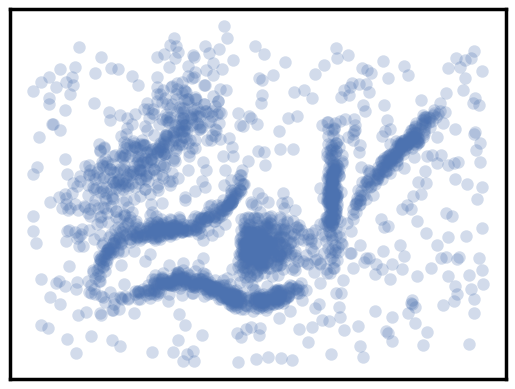

In [242]:
data = np.load('../datasets/clusterable_data.npy')

# Iris is too small
# iris = load_iris()
# X, y = iris['data'], iris['target'] 

# pca = PCA(n_components=2)
# data = pca.fit_transform(X)

plt.scatter(data.T[0], data.T[1], c='b', **plot_kwds)

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

**K-Means**

• Предполагает, что кластеры шарообразные

• Распределяет все точки, не фильтрует шумы

• Нужно знать/предполагать сколько кластеров конкретно

• Не самый стабильный

• Производительный

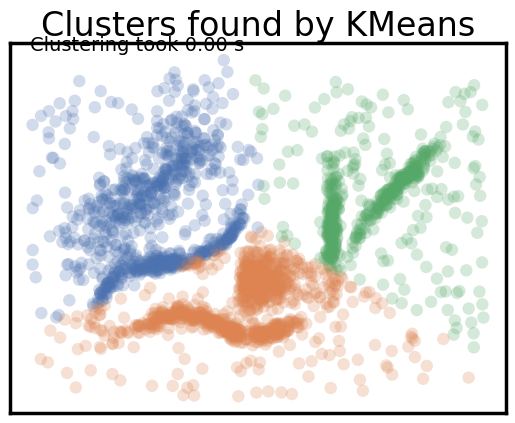

In [243]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters':3})

**Affinity Propagation(Распространение близости)**

• Графовый подход

• Точки сами "голосуют" за свой кластер, нет нужды знать кол-во кластеров

• Шарообрзные кластеры

• Независимы от метрики различия

• Стабильнее чем K-Means, но не сильно лучше

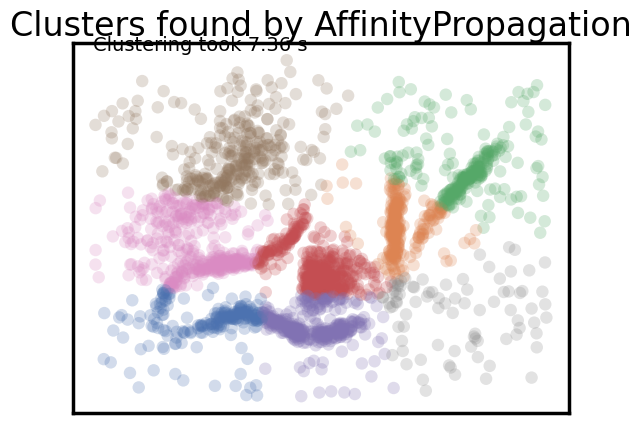

In [244]:
plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})
# Preference определяет, насколько вероятно, что определенная точка будет выбрана в качестве экземпляра (центра кластера)
# Чем больше preference, тем больне кластеров
# По умолчанию часто используют среднее или медианное значение схожести (similarity) между точками.

# Damping влияет на устойчивость алгоритма и предотвращает его расхождение, Диапазон (0.5, 1)
# Чем больше, тем стабильнее, но медленнее схождение(кол-во итераций для достижения стабильного состояния)

**Mean Shift (Среднее смещение)**

Идея - существует некоторая функция плотности вероятности, из которой взяты данные, и он пытается разместить центроиды кластеров в максимумах этой функции плотности

Алгоритм использует ядерную оценку плотности (KDE, Kernel Density Estimation), чтобы оценить, насколько "плотно" распределены точки в разных областях пространства

Ядро — это функция (обычно гауссовская), которая определяет, как сильно влияет каждая точка данных на оценку плотности.

Ширина полосы (bandwidth) определяет, на каком расстоянии точки всё ещё считаются "близкими". Это ключевой параметр:
Маленькая ширина → учитываются только близкие точки → больше мелких кластеров.
Большая ширина → учитываются дальние точки → меньше кластеров.

• Кластеризует не каждую точку, но кластеры шарообразные (есть шумы)

• Может отбрасывать шумы

• Стабилность сильно зависит от изменения bandwidth + есть случайная инициализация

• Слабая производительность

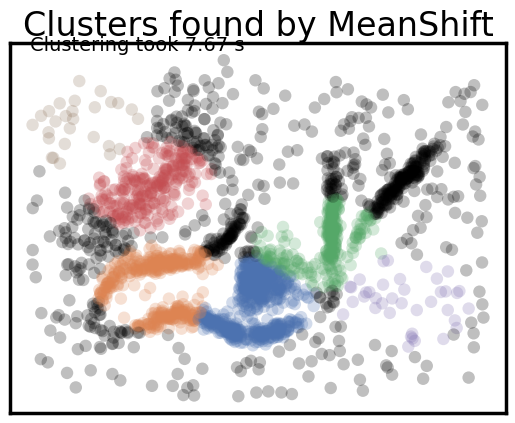

In [245]:
plot_clusters(data, cluster.MeanShift, (), {'bandwidth': 0.160, 'cluster_all': False})

**Spectral clustering (Спектральная кластеризация)**

Кластеризация графов - строит граф расстояния между точками, использует собственные векторы, чтобы построить низкоразмерный граф в евклидовом пространстве

Суть - преобразования нашего исходного пространства таким образом, чтобы лучше представлять расстояния между множествами для некоторого множества, на котором, как предполагается, лежат данные. Как только мы получили преобразованное пространство, запускается стандартный алгоритм кластеризации(K-Means в sklearn)

• Шарообразность кластеров в преобразованном пространстве, а не в исходном(лучше точность)

• Наследуются проблемы K-Means(Разбиваем данные, а не кластеризуем -> шум, кол-во кластеров -> знаем/угадываем, стабильность -> Немного стабильнее, чем K-Means, но страдает)

• Плотный граф(близкие точки) - слишком плохая производительность

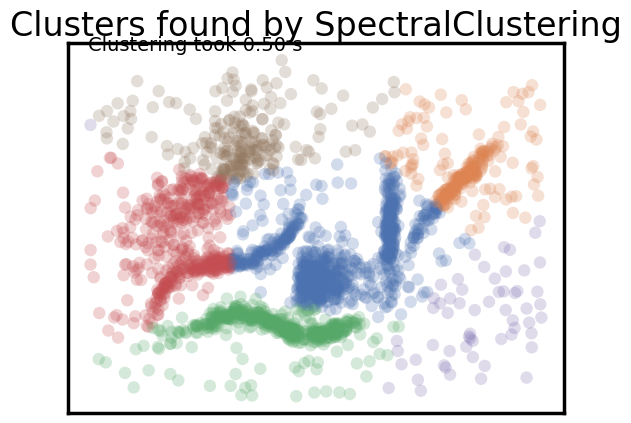

In [246]:
plot_clusters(data, cluster.SpectralClustering, (), {'n_clusters':6}) 

**Agglomerative clustering (Агломеративная кластеризация)**

Кластеры итеративно сливаются по какому-либо правилу(дефолт - сливаются ближайшие), пока не останется единый кластер. Результат - бинарное дерево, представляющее слои кластеров

• Кластеры не шаровидные

• Есть возможность посмотреть дендрограмму

• Стабильность

• Остаются шумы

• В Sklearn слабая производительность, но есть fastcluster

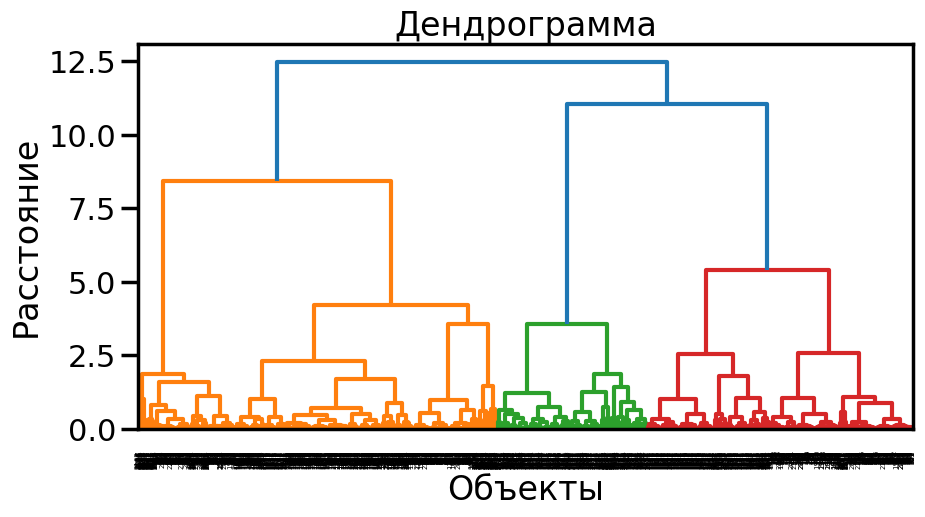

In [247]:
import scipy.cluster.hierarchy as sch

linkage_matrix = sch.linkage(data, method='ward')

# Строим дендрограмму
plt.figure(figsize=(10, 5))
sch.dendrogram(linkage_matrix)
plt.title("Дендрограмма")
plt.xlabel("Объекты")
plt.ylabel("Расстояние")
plt.show()

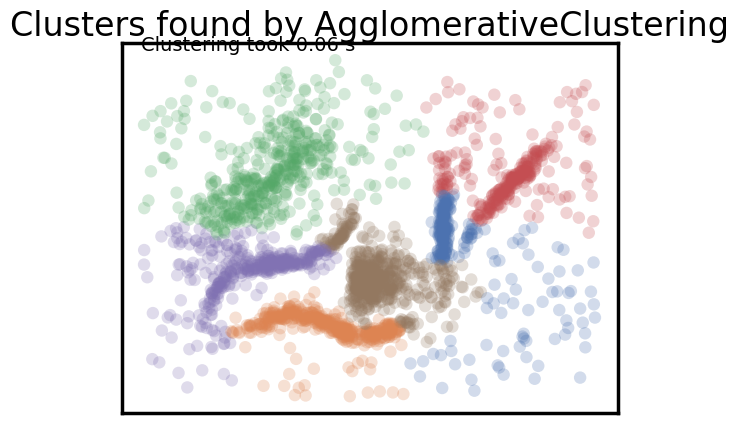

In [248]:
plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

**DBSCAN**

Основан на плотности, не требует, чтобы каждая точка была отнесена к кластеру, и, следовательно, не разбивает данные, а извлекает «плотные» кластеры и оставляет разреженный фон в качестве шума

Разрежает пространство (отдаляет шумовые точки вне кластера), после чего применяет алгоритм как у Агломеративной кластеризации

Результат работы с кластерами переменной плотности зависит от параметров

Epsilon - расстояние

• Не шарообразные кластеры

• Нет шума

• Стабильность

• Производительность

• Кластеры примерно одной плотности

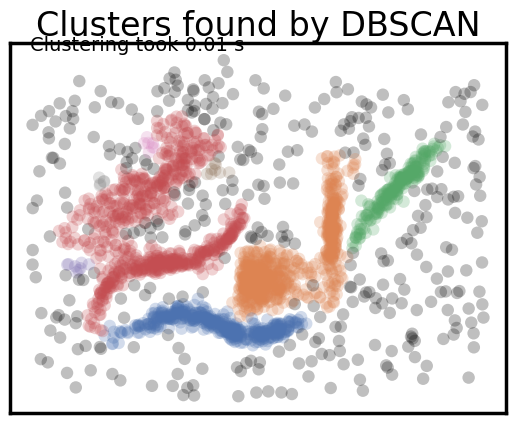

In [249]:
plot_clusters(data, cluster.DBSCAN, (), {'eps':0.025})

**HDBSCAN**

DBSCAN, переосмысленный для создания кластеров с различной плотностью. Вследствие уплотнения дендограммы путем разбиений с наименьшим количеством выпадающих точек, получается компактное дерево с наименьшими потерями точек

• Кластеры различной плотности

• Нет epsilon'а (min_cluster_size вместо него)

• Все достоинства DBSCAN

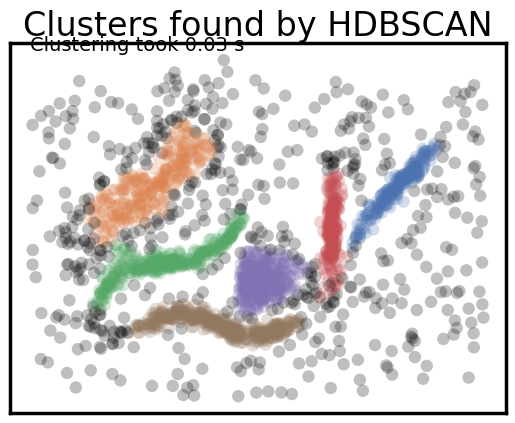

In [250]:
import hdbscan

plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':15})

**OPTICS**

Почти тот же DBSCAN только с обнаружением кластеров разной плотности и другой метрикой расстояния

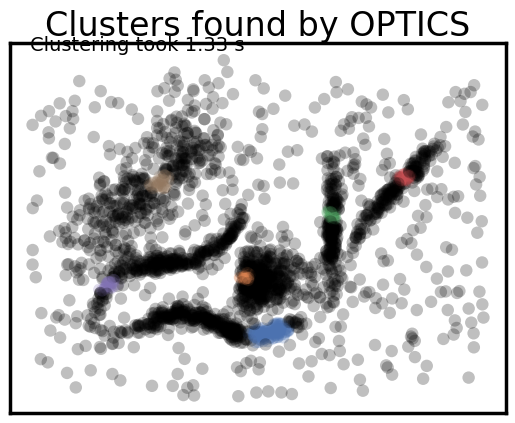

In [251]:
plot_clusters(data, cluster.OPTICS, (), {'min_samples':11, "max_eps":0.9, "xi":0.08, "min_cluster_size":20})